In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import graphviz
import pydotplus
import io
from scipy import misc

from mlxtend.plotting import plot_decision_regions

In [6]:
all_dataset = pd.read_csv("data/arrhythmia.data", header=None)

In [28]:
chosen_column = [0] + [i for i in range(3, 15)] + [all_dataset.columns[-1]]
max_trash = 20
_SEED_ = 30
random.seed(_SEED_)

In [29]:
def clean_data(data):
    for col in data.columns:
        trash_row = (data[col] == "?")
        good_row = (data[col] != "?")
        if sum(trash_row) < max_trash:
            data = data[good_row]
        else:
            aver =  pd.to_numeric(data[good_row][col]).mean()
            data.loc[trash_row, col] = aver
        data[col] = pd.to_numeric(data[col])
        data[col] -= data[col].min()
    return data

In [30]:
def split_train_test(df):
    margin = int(0.8 * len(df))
    df = df.sample(frac=1, random_state=_SEED_)
    train = df.iloc[:margin]
    test = df.iloc[margin:]
    return train, test

In [31]:
def from_data_to_xy(data):
    x = np.array(data[data.columns[:-1]], dtype=float)
    y = np.array(data[data.columns[-1]], dtype=float)
    return x, y

In [21]:
def clf_acc(data, clf):
    train_data, test_data = split_train_test(data)
    train_x, train_y = from_data_to_xy(train_data)
    test_x, test_y = from_data_to_xy(test_data)
    clf_fit = clf.fit(train_x, train_y)
    y_pred_train = clf_fit.predict(train_x)
    y_pred_test = clf_fit.predict(test_x)
    acc_pred_train = sum(y_pred_train == train_y)  / train_y.shape[0]
    acc_pred_test = sum(y_pred_test == test_y)  / test_y.shape[0]
    return acc_pred_train, acc_pred_test, clf_fit

In [12]:
dataset = all_dataset[chosen_column]
clean_dataset = clean_data(dataset)

/home/ahavriushen/Desktop/uni_proj/stat_learning/venv/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [13]:
def cv_accuracy(data, classifier, num_iter=100):
    accuracy = []
    for i in range(num_iter):
        acc = clf_acc(data, classifier)
        accuracy.append(acc)
    return accuracy

In [14]:
def show_tree(tree, features, path):
    f = io.StringIO()
    export_graphviz(tree, out_file=f, feature_names=features)
    pydotplus.graph_from_dot_data(f.getvalue()).write_png(path)
    #img = misc.imread(path)
    img = plt.imread(path)
    plt.rcParams["figure.figsize"] = (20, 20)
    plt.imshow(img)

In [15]:
## accuracy = 0.53 for full tree
## accuracy with min_samples_split=10 => 0.56
## accuracy with min_samples_split=10 => 0.59
##({'max_depth': 6, 'min_samples_split': 24}, 0.6175637393767706, 0.6741573033707865)
##({'max_depth': 7, 'min_samples_split': 18}, 0.6005665722379604, 0.6404494382022472)

In [12]:
def grid_search(data_, clf, param, scoring):
    train_data, test_data = split_train_test(data_)
    train_x, train_y = from_data_to_xy(train_data)
    test_x, test_y = from_data_to_xy(test_data)
    grid_clf = GridSearchCV(clf, param, cv=10, scoring=scoring, n_jobs=-1)
    grid_clf_fit = grid_clf.fit(train_x, train_y)
    model = grid_clf_fit.best_estimator_
    model_fit = model.fit(train_x, train_y)
    y_pred = model_fit.predict(test_x)
    acc = sum(y_pred == test_y)  / test_y.shape[0]
    return grid_clf_fit.best_params_, grid_clf_fit.best_score_, acc, model_fit

In [38]:
param_dt={'min_samples_split': range(2, 80, 2),
          'max_depth': range(1, 40, 2)}
clf_dt = DecisionTreeClassifier()
answer_dt = grid_search(clean_dataset, clf_dt, param_dt, 'accuracy')
print(answer_dt[:-1])
#show_tree(answer_dt[-1], chosen_column[:-1], "dec_tree_02.png")

/home/ahavriushen/Desktop/uni_proj/stat_learning/venv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


({'max_depth': 3, 'min_samples_split': 24}, 0.6515580736543909, 0.5617977528089888)


/home/ahavriushen/Desktop/uni_proj/stat_learning/venv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [39]:
##best boosting ({'learning_rate': 0.15, 'max_depth': 3}, 0.6260623229461756, 0.5955056179775281)  where n_estimators=20
##({'learning_rate': 0.1, 'max_depth': 3}, 0.6147308781869688, 0.651685393258427) for n_estimators=15, min_samples_split=5
#({'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 6, 'n_estimators': 20}, 0.6118980169971672, 0.6629213483146067)
##({'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 40}, 0.6288951841359773, 0.6404494382022472)
##({'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 40}, 0.6147308781869688, 0.6966292134831461)

In [62]:
clf_boost = GradientBoostingClassifier(loss='deviance', min_samples_split=6)
param_boost = {"learning_rate": [0.05, 0.075, 0.1, 0.15, 0.2],
              "max_depth": range(3, 12, 2),
              "n_estimators": [10, 20, 30, 40]}
              #"min_samples_split": [2, 4, 6, 8, 10]
answer_boost = grid_search(clean_dataset, clf_boost, param_boost, 'accuracy')
print(answer_boost[:-1])

/home/ahavriushen/Desktop/uni_proj/stat_learning/venv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/ahavriushen/Desktop/uni_proj/stat_learning/venv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


({'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 30}, 0.6118980169971672, 0.651685393258427)


In [ ]:
##({'criterion': 'gini', 'max_depth': 12, 'max_features': 'log2', 'n_estimators': 75}, 0.6685552407932012, 0.6404494382022472)
##({'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 75}, 0.6628895184135978, 0.6629213483146067)
##({'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 80}, 0.6515580736543909, 0.6741573033707865)

In [37]:
clf_rf = RandomForestClassifier(bootstrap=True, criterion='gini')
param_rf = {
    'n_estimators': [30, 50, 70, 80, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': range(2, 20, 2)
}
answer_rf = grid_search(clean_dataset, clf_rf, param_rf, 'accuracy')
print(answer_rf[:-1])

/home/ahavriushen/Desktop/uni_proj/stat_learning/venv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/ahavriushen/Desktop/uni_proj/stat_learning/venv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


({'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 80}, 0.6515580736543909, 0.6741573033707865)


In [22]:
def choose_best_columns(data, clf, feature_names, target_name, if_sort=True):
    list_of_res = []
    for f1_num in range(len(feature_names)):
        for f2_num in range(f1_num + 1, len(feature_names)):
            column_temp = [feature_names[f1_num], feature_names[f2_num], target_name]
            acc_train, acc_test, _ = clf_acc(data[column_temp], clf)            
            list_of_res.append({
                "columns": column_temp,
                "accuracy train": acc_train,
                "accuracy test": acc_test 
            })
    if if_sort:
        list_of_res = sorted(list_of_res, reverse=True,
                             key=lambda res: 1.5*res["accuracy test"] + res["accuracy train"])
    return list_of_res

In [56]:
clf_dt_best = DecisionTreeClassifier(max_depth=6, min_samples_split=20)
clf_boost_best = GradientBoostingClassifier(n_estimators=40, learning_rate=0.1, max_depth=5, loss='deviance', min_samples_split=6)
clf_rf_best = RandomForestClassifier(n_estimators=75, max_depth=10, bootstrap=True, criterion='gini', max_features='auto')

In [57]:
def plot_2d_proj(data, clf):
    find_column_res = choose_best_columns(data, clf, chosen_column[:-1], chosen_column[-1])
    #print(find_column_res[:3])
    best_columns = dt_res[0]["columns"]
    loc_data = data[best_columns]
    ac_train, ac_test, clf_fit = clf_acc(loc_data, clf)
    print(ac_train, ac_test)
    x, y = from_data_to_xy(loc_data)
    plot_decision_regions(x, y.astype(np.integer), clf=clf_fit, legend=0)
    plt.show()

0.9801699716713881 0.5393258426966292


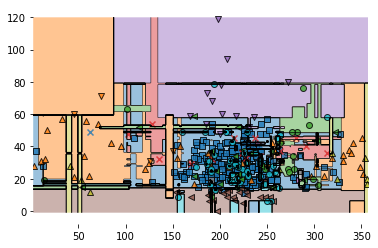

In [58]:
plot_2d_proj(clean_dataset, clf_boost_best)